In [1]:
import pandas as pd         
import gc                         
gc.enable() 

# 1. Data preparation

In [2]:
orders = pd.read_csv("C:/Users/Nataša/Desktop/Big Data Project/orders.csv")
products = pd.read_csv("C:/Users/Nataša/Desktop/Big Data Project/products.csv")

order_products_train = pd.read_csv("C:/Users/Nataša/Desktop/Big Data Project/order_products__train.csv")
order_products_prior = pd.read_csv("C:/Users/Nataša/Desktop/Big Data Project/order_products__prior.csv")

departments = pd.read_csv("C:/Users/Nataša/Desktop/Big Data Project/departments.csv")
aisles = pd.read_csv("C:/Users/Nataša/Desktop/Big Data Project/aisles.csv")

In [3]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [5]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [3]:
# convert character variables into categories 

aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

### Create DF with the orders and the products that have been purchased on prior orders (op)

In [4]:
orders.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0


In [5]:
order_products_prior.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0


In [6]:
# how = 'inner' returns records that have matching values in both DF

op = orders.merge(order_products_prior, on='order_id', how='inner')
op.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0


# 2. Create predictor variables

## 2.1 User predictors

### 2.1.1 Number of orders per customer

In [7]:
# Create distinct groups for each user, identify the highest order number in each group, save the new column to DF

user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
user.head(3)

,u_total_orders
user_id,
1,10
2,14
3,12


In [8]:
# Reset the index of the DF so to bring user_id from index to column

user = user.reset_index()
user.head(3)

,user_id,u_total_orders
0,1,10
1,2,14
2,3,12


### 2.1.2 How frequent a customer has reordered products

In [9]:
# for each user_id calculate the mean or 'reordered' products

u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()
u_reorder.head(3)

,user_id,u_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000


In [10]:
# Merge it with the 'user' DF. 
# How='left' because we want to keep all the users that we have in 'user' DF

user = user.merge(u_reorder, on='user_id', how='left')

del u_reorder
gc.collect()

user.head(3)

,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000


## 2.2 Product predictors

### 2.2.1 Number of purchases for each product

In [11]:
# For each product_id calculate the total number of purchases

prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd = prd.reset_index()
prd.head(3)

,product_id,p_total_purchases
0,1,1852
1,2,90
2,3,277


### 2.2.2 What is the probability of a product to be reordered

In [13]:
# remove products with less than 40 purchases - filter with .shape[0]
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >40)
p_reorder.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0


In [14]:
# P_reordered(product_id) = number of reorders / total number of orders == mean

p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
p_reorder.head(3)

,product_id,p_reorder_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852


In [15]:
# Merge it on prd DF which keep all the features based on products
# How='left' because we want to keep all the products we have in prd DF

prd = prd.merge(p_reorder, on='product_id', how='left')

del p_reorder
gc.collect()

prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,NaN


In [16]:
# Fill NaN values (products with less than 40 purchases) with 0

prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.000000


## 2.3 User-product predictors

### 2.3.1 How many times a user brought a product

In [17]:
# For each user-product combination count the total numbers of orders

uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
uxp = uxp.reset_index()
uxp.head(3)

,user_id,product_id,uxp_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1


### 2.3.2 How frequently a customer brought a product after its first purchase

In [69]:
# P_reordered(user_id,product_id) = times user bought N/ total orders placed since the first users order of a product

#### Times_bought_N

In [19]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
times.head(3)

Times_Bought_N
user_id product_id                
1       196                     10
        10258                    9
        10326                    1

#### Order range

In [20]:
# total orders for each user

total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders.head(3)

,total_orders
user_id,
1,10
2,14
3,12


In [21]:
# for each user-product combination take the first order number

first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no  = first_order_no.reset_index()
first_order_no.head(3)

,user_id,product_id,first_order_number
0,1,196,1
1,1,10258,2
2,1,10326,5


In [22]:
# We merge the first order number with the total_orders DF. 
# How='right' because first_order_no refers to unique combinations of user and product

span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
span.head(3)

,user_id,total_orders,product_id,first_order_number
0,1,10,196,1
1,1,10,10258,2
2,1,10,10326,5


In [23]:
# calculate order range

span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
span.head(3)

,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,196,1,10
1,1,10,10258,2,9
2,1,10,10326,5,6


#### Create the final ratio 'uxp_reorder_ratio'

In [24]:
# Merge 'times' and 'span'
# As both variables derived from the combination of users & products,any type of join will keep all the combinations.

uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
uxp_ratio.head(3)

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,1,196,10,10,1,10
1,1,10258,9,10,2,9
2,1,10326,1,10,5,6


In [25]:
# calculate reorder ratio = times user bought N/ total orders placed since the first users order of a product

uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head(3)

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_reorder_ratio
0,1,196,10,10,1,10,1.000000
1,1,10258,9,10,2,9,1.000000
2,1,10326,1,10,5,6,0.166667


In [26]:
# drop unimportant variables

uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
uxp_ratio.head(3)

,user_id,product_id,uxp_reorder_ratio
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667


In [27]:
del [times, first_order_no, span]

#### Merge the final uxpratio with uxp DF

In [28]:
# How = 'left' because we want to keep all the user-products that we have created on the uxp DF

uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio

uxp.head(3)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,1,196,10,1.000000
1,1,10258,9,1.000000
2,1,10326,1,0.166667


## 2.4 Merge all features

In [29]:
user.head(1)

,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915


In [30]:
prd.head(1)

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391


In [31]:
uxp.head(1)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,1,196,10,1.0


In [32]:
# uxp and user into 'data'

data = uxp.merge(user, on='user_id', how='left')
data.head(3)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio
0,1,196,10,1.000000,10,0.694915
1,1,10258,9,1.000000,10,0.694915
2,1,10326,1,0.166667,10,0.694915


In [33]:
# data and prd

data = data.merge(prd, on='product_id', how='left')
data.head(3)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,196,10,1.000000,10,0.694915,35791,0.776480
1,1,10258,9,1.000000,10,0.694915,1946,0.713772
2,1,10326,1,0.166667,10,0.694915,5526,0.652009


# 3. Create train and test DF

## 3.1 Include info about the last order of each user

In [34]:
orders.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0


In [35]:
# keep only the future orders from all customers: train and test (not prior-used for predictors)

orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]
orders_future.head(3)

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568


In [36]:
# merge data with orders_future

data = data.merge(orders_future, on='user_id', how='left')
data.head(3)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
0,1,196,10,1.000000,10,0.694915,35791,0.776480,train,1187899
1,1,10258,9,1.000000,10,0.694915,1946,0.713772,train,1187899
2,1,10326,1,0.166667,10,0.694915,5526,0.652009,train,1187899


## 3.2 Prepare the train DF

In [37]:
# we keep only users who are labelled as 'train', for them we got the order_products_train

data_train = data[data.eval_set=='train']
data_train.head(3)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
0,1,196,10,1.000000,10,0.694915,35791,0.776480,train,1187899
1,1,10258,9,1.000000,10,0.694915,1946,0.713772,train,1187899
2,1,10326,1,0.166667,10,0.694915,5526,0.652009,train,1187899


In [38]:
# merge data_train and order_products_train

data_train = data_train.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
data_train.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id,reordered
0,1,196,10,1.000000,10,0.694915,35791,0.776480,train,1187899,1.0
1,1,10258,9,1.000000,10,0.694915,1946,0.713772,train,1187899,1.0
2,1,10326,1,0.166667,10,0.694915,5526,0.652009,train,1187899,NaN
3,1,12427,10,1.000000,10,0.694915,6476,0.740735,train,1187899,NaN
4,1,13032,3,0.333333,10,0.694915,3751,0.657158,train,1187899,1.0


In [39]:
# fill NaN values with 0

data_train['reordered'] = data_train['reordered'].fillna(0)
data_train.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id,reordered
0,1,196,10,1.000000,10,0.694915,35791,0.776480,train,1187899,1.0
1,1,10258,9,1.000000,10,0.694915,1946,0.713772,train,1187899,1.0
2,1,10326,1,0.166667,10,0.694915,5526,0.652009,train,1187899,0.0
3,1,12427,10,1.000000,10,0.694915,6476,0.740735,train,1187899,0.0
4,1,13032,3,0.333333,10,0.694915,3751,0.657158,train,1187899,1.0


In [40]:
# set user_id and product_id as the index of DF

data_train = data_train.set_index(['user_id', 'product_id'])
data_train.head(3)

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
1       196                       10           1.000000              10   
        10258                      9           1.000000              10   
        10326                      1           0.166667              10   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
1       196                  0.694915              35791         0.776480   
        10258                0.694915               1946         0.713772   
        10326                0.694915               5526         0.652009   

                   eval_set  order_id  reordered  
user_id product_id                                
1       196           train   1187899        1.0  
        10258         train   1187899        1.0  
        10326         train   1187899        0.0

In [41]:
# remove columns which are not predictors 

data_train = data_train.drop(['eval_set', 'order_id'], axis=1)

## 3.3 Prepare the test DF

In [42]:
# same structure as the train DF, excluding the 'reordered' last column as it is the label that we want to predict
# keep only the future orders from customers labelled as test

data_test = data[data.eval_set=='test']
data_test.head(3)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
120,3,248,1,0.090909,12,0.625,6371,0.400251,test,2774568
121,3,1005,1,0.333333,12,0.625,463,0.440605,test,2774568
122,3,1819,3,0.333333,12,0.625,2424,0.492162,test,2774568


In [43]:
# We set user_id and product_id as the index of the DF

data_test = data_test.set_index(['user_id', 'product_id'])
data_test.head(3)

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
3       248                        1           0.090909              12   
        1005                       1           0.333333              12   
        1819                       3           0.333333              12   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
3       248                     0.625               6371         0.400251   
        1005                    0.625                463         0.440605   
        1819                    0.625               2424         0.492162   

                   eval_set  order_id  
user_id product_id                     
3       248            test   2774568  
        1005           test   2774568  
        1819           test   2774568

In [44]:
# remove columns which are not predictors 

data_test = data_test.drop(['eval_set', 'order_id'], axis=1)

# 4. Create predictive model

## 4.1 Train XGBoost

XGBoost stands for eXtreme Gradient Boosting, an algorithm that is used in many winning solutions for Kaggle competitions.

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

In [45]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import f1_score, classification_report
from scikitplot.metrics import plot_confusion_matrix
from scikitplot.classifiers import plot_feature_importances

In [46]:
X = data_train.drop('reordered', axis=1)
y = data_train.reordered

In [47]:
X.shape

(8474661, 6)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [49]:
del [data_train]
gc.collect()

20

In [50]:
# Setting boosters parameters

parameters = {
    'eavl_metric' : 'logloss',
    'max_depth' : 5,
    'colsample_bytree' : 0.4,
    'subsample' : 0.8
}

In [51]:
# Initializing the model

xgb = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10)

In [52]:
# Fitting the model

model = xgb.fit(X_train, y_train)

[16:57:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "parameters" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [53]:
model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'approx',
 'validate_parameters': 1,
 'verbosity': None,
 'parameters': {'eavl_metric': 'logloss',
  'max_depth': 5,
  'colsample_bytree': 0.4,
  'subsample': 0.8},
 'num_boost

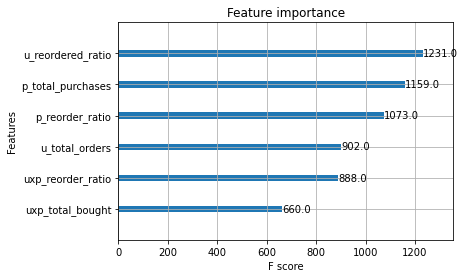

In [54]:
import xgboost as xgb
xgb.plot_importance(model)

### Evaluation

In [55]:
y_pred = model.predict(X_test).astype(int)
y_pred[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

F1 Score: 0.24270931936358095
              precision    recall  f1-score   support

           0       0.99      0.92      0.95   2482090
           1       0.15      0.62      0.24     60309

    accuracy                           0.91   2542399
   macro avg       0.57      0.77      0.60   2542399
weighted avg       0.97      0.91      0.93   2542399



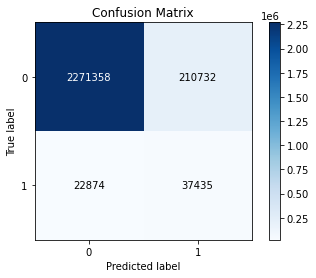

In [56]:
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print(classification_report(y_pred, y_test))
plot_confusion_matrix(y_pred, y_test)

# 5. Apply predictive model on test data

In [57]:
y_pred_test = model.predict(data_test).astype(int)

In [58]:
y_pred_test[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [59]:
data_test['prediction'] = y_pred_test
data_test.head()

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
3       248                        1           0.090909              12   
        1005                       1           0.333333              12   
        1819                       3           0.333333              12   
        7503                       1           0.100000              12   
        8021                       1           0.090909              12   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
3       248                     0.625               6371         0.400251   
        1005                    0.625                463         0.440605   
        1819                    0.625               2424         0.492162   
        7503                    0.625              12474         0.553551   
        8021                    0.625              27864         0.591157   

                    prediction  
user_id product_id              
3       248                  0  
        1005                 0  
        1819                 0  
        7503                 0  
        8021                 0

In [60]:
# Reset the index

final = data_test.reset_index()

In [61]:
# keep only required columns

final = final[['product_id', 'user_id', 'prediction']]

gc.collect()
final.head()

,product_id,user_id,prediction
0,248,3,0
1,1005,3,0
2,1819,3,0
3,7503,3,0
4,8021,3,0


# 6. Submission file

In [62]:
orders_test = orders.loc[orders.eval_set=='test',("user_id", "order_id") ]
orders_test.head()

,user_id,order_id
38,3,2774568
44,4,329954
53,6,1528013
96,11,1376945
102,12,1356845


In [63]:
final = final.merge(orders_test, on='user_id', how='left')
final.head()

,product_id,user_id,prediction,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,0,2774568
3,7503,3,0,2774568
4,8021,3,0,2774568


In [64]:
# remove user_id column because we care only about order_id
final = final.drop('user_id', axis=1)

In [65]:
# convert product_id as integer
final['product_id'] = final.product_id.astype(int)

In [66]:
## Remove all unnecessary objects

del orders
del orders_test
gc.collect()

final.head()

,product_id,prediction,order_id
0,248,0,2774568
1,1005,0,2774568
2,1819,0,2774568
3,7503,0,2774568
4,8021,0,2774568


In [67]:
d = dict()
for row in final.itertuples():
    if row.prediction== 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in final.order_id:
    if order not in d:
        d[order] = 'None'
        
gc.collect()

20

In [68]:
#Convert the dictionary into a DataFrame
sub = pd.DataFrame.from_dict(d, orient='index')

#Reset index
sub.reset_index(inplace=True)
#Set column names
sub.columns = ['order_id', 'products']

sub.head()

,order_id,products
0,2774568,21903 39190 47766
1,1416320,5134 21137 21903
2,1735923,17008
3,1980631,6184 9387 13575 13914 22362 41400 46061
4,3202221,4793 9637 24852
